# Evaluating Wind Turbine Performance Improvement Using Regression
A renewable energy company wants to evaluate and quantify the improvement in a wind turbine's energy generation performance after installing hardware on the turbine's blades claimed to improve aerodynamics. This project aims to model the wind turbine generation before and after the improvement activities were done, excluding any other factors that may affect the turbine generation such as difference in wind speed, turbine stoppages, and grid curtailment, and compare the predictions of the models to determine whether there is an improvement in generation, and by how much.

## 1. Configuration
The data source files are SCADA extracts containing 1 year of data of 1 wind turbine per file. The filenames are formatted as "*SL##-yyyy.csv*"
where:
- *\##* - wind turbine number (2 digits)
- *yyyy* - year (4 digits)

*(e.g. SL01-2021.csv, SL24-2022.csv)*

In [1]:
# wind turbine number (1-2 digit integer)
wtn = 1
# wind turbine maximum power output (kW)
capacity = 2000

In [2]:
# year range (4-digit integers)
# For a single file (year), input the same value for year_start and year_end
year_start = 2021
year_end = 2023

In [3]:
# data granularity (in minutes, integer)
gran = 10

#### Date of Wind Turbine Improvement Activities
The start and end dates of the blade hardware installation activities will be the basis for splitting the data into the *Before* and *After* improvement states for evaluation of performance improvement.

In [4]:
# start and end dates of improvement activities (in "yyyy-mm-dd" string format)
act_date_start = "2022-10-13"
act_date_end = "2022-11-04"

#### Loading the Python Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_regression
from numpy.random import seed
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.neural_network import MLPRegressor
from scipy.stats import weibull_min
from sklearn.base import clone

# Custom Functions Module
%run -i Modules/WTPerfImprovRegMod.ipynb.ipynb

## 2. Reading the Data

In [6]:
# read the data and save to a dataframe
df_raw = pd.DataFrame()
for year in range(year_start, year_end + 1):
    filename = 'SL'+"{:02d}".format(wtn)+'-'+str(year)+'.csv'
    # Date/Time data should be converted to datetime format
    df_raw = pd.concat([df_raw, pd.read_csv('Dataset\\'+filename, parse_dates=['dtFecha'])], axis=0)
    print(filename+' loaded')

SL01-2021.csv loaded
SL01-2022.csv loaded
SL01-2023.csv loaded


In [7]:
# peak at the first few rows of data
df_raw.head()

,idDatosDiezminutales,wtg_Idn,Naerogenerador,dtFecha,dPotTotal,dPotReact,dVelVientoF1sg,dCosPhi,dTempGen,dPosNacelle,ET_Availability2Avg,dTempAmbiente,dDirViento,dVelGenerador,dPresGH,dPitch
0,11649407,SL01,1,2021-01-01 00:00:00,217.3286,-33.1883,5.3680,0.9813,71.7783,17.1074,100.0,26.7471,357.2904,1321.3120,189.7867,0.1457
1,11649408,SL01,1,2021-01-01 00:10:00,354.6371,-29.4117,6.1840,0.9954,71.7830,13.4375,100.0,26.8625,4.6345,1487.5857,190.0089,-0.1600
2,11649565,SL01,1,2021-01-01 00:20:00,446.6210,-27.4115,6.6037,0.9968,71.7820,22.0488,100.0,26.9332,0.5823,1580.1943,189.6752,-0.1333
3,11649566,SL01,1,2021-01-01 00:30:00,484.7859,-29.8035,6.7293,0.9975,71.8003,26.0937,100.0,26.9741,358.2383,1645.1169,189.8796,-0.1127
4,11649567,SL01,1,2021-01-01 00:40:00,710.9668,-46.9165,7.4237,0.9969,72.1896,26.0937,100.0,27.0233,355.4533,1822.1286,189.9573,-0.0117


## 3. Data Wrangling

In [8]:
# select only the subset containing relevant columns of data (chosen based on data dictionary)
df1 = df_raw[["dtFecha",
        "dPotTotal",
        "dVelVientoF1sg",
        "dDirViento",
        "dPosNacelle",
        "dPitch",
        "dTempAmbiente",
        "dTempGen",
        "dVelGenerador",
        "dCosPhi",
        "dPresGH",
        "ET_Availability2Avg"]]

# rename the columns for easier understanding (named based on data dictionary)
df1.columns = ["DateTime",
              "Power",
              "WindSpeed",
              "WindDirection",
              "NacellePosition",
              "PitchAngle",
              "AmbientTemp",
              "GeneratorTemp",
              "GeneratorRPM",
              "PowerFactor",
              "HydraulicPressure",
              "Availability"]

In [9]:
# set the DateTime as the index
df1.set_index("DateTime", inplace=True)

In [10]:
# check columns and datatypes
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 129248 entries, 2021-01-01 00:00:00 to 2023-07-11 23:50:00
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Power              129248 non-null  float64
 1   WindSpeed          129248 non-null  float64
 2   WindDirection      128672 non-null  float64
 3   NacellePosition    128672 non-null  float64
 4   PitchAngle         128672 non-null  float64
 5   AmbientTemp        128672 non-null  float64
 6   GeneratorTemp      128672 non-null  float64
 7   GeneratorRPM       128672 non-null  float64
 8   PowerFactor        128672 non-null  float64
 9   HydraulicPressure  128672 non-null  float64
 10  Availability       128672 non-null  float64
dtypes: float64(11)
memory usage: 11.8 MB


In [11]:
# check count of null values per column
df1.isna().sum()

Power                  0
WindSpeed              0
WindDirection        576
NacellePosition      576
PitchAngle           576
AmbientTemp          576
GeneratorTemp        576
GeneratorRPM         576
PowerFactor          576
HydraulicPressure    576
Availability         576
dtype: int64

In [12]:
# drop all rows with null values
df1 = df1.dropna()

# check the dimensions of the remaining dataframe
df1.shape

(128672, 11)

In [13]:
# peak at the first few rows of the updated dataframe
df1.head()

,Power,WindSpeed,WindDirection,NacellePosition,PitchAngle,AmbientTemp,GeneratorTemp,GeneratorRPM,PowerFactor,HydraulicPressure,Availability
DateTime,,,,,,,,,,,
2021-01-01 00:00:00,217.3286,5.3680,357.2904,17.1074,0.1457,26.7471,71.7783,1321.3120,0.9813,189.7867,100.0
2021-01-01 00:10:00,354.6371,6.1840,4.6345,13.4375,-0.1600,26.8625,71.7830,1487.5857,0.9954,190.0089,100.0
2021-01-01 00:20:00,446.6210,6.6037,0.5823,22.0488,-0.1333,26.9332,71.7820,1580.1943,0.9968,189.6752,100.0
2021-01-01 00:30:00,484.7859,6.7293,358.2383,26.0937,-0.1127,26.9741,71.8003,1645.1169,0.9975,189.8796,100.0
2021-01-01 00:40:00,710.9668,7.4237,355.4533,26.0937,-0.0117,27.0233,72.1896,1822.1286,0.9969,189.9573,100.0


## 4. Exploratory Data Analysis

In [14]:
# print the summary statistics
df1.describe()

,Power,WindSpeed,WindDirection,NacellePosition,PitchAngle,AmbientTemp,GeneratorTemp,GeneratorRPM,PowerFactor,HydraulicPressure,Availability
count,128672.000000,128672.000000,128672.000000,128672.000000,128672.000000,128672.000000,128672.000000,128672.000000,128672.000000,128672.000000,128672.000000
mean,375.430161,5.259404,176.957049,112.363636,9.024808,27.575979,75.380122,1248.296510,0.734875,180.856645,93.237466
std,474.816639,2.886921,170.381534,107.994124,21.883551,5.330403,18.998890,622.324105,0.337626,39.573580,24.755157
min,-30.186200,0.000000,0.000000,0.000000,-0.974000,0.000000,0.000000,-32.460800,0.000000,0.000000,0.000000
25%,0.000000,2.920700,3.061900,27.450800,-0.040000,27.372700,70.823525,1221.894200,0.532200,189.407775,100.000000
50%,185.245600,5.219700,131.569750,50.468800,0.601300,28.483250,77.642850,1279.008150,0.939500,189.795500,100.000000
75%,569.039050,7.102000,356.449125,222.198450,2.733000,29.576825,82.613400,1702.636125,0.994800,190.150525,100.000000
max,2000.234300,19.665300,359.999800,359.991500,90.000000,33.944800,138.351400,2019.600500,0.999100,193.650800,100.000000


There should be no negative Power values.

In [15]:
# count the number of rows with negative Power values
len(df1[df1.Power < 0])

28636

In [16]:
# replace negative Power values with zero
df1.loc[df1.Power < 0, "Power"] = 0

# check the updated summary statistics
df1.describe()

,Power,WindSpeed,WindDirection,NacellePosition,PitchAngle,AmbientTemp,GeneratorTemp,GeneratorRPM,PowerFactor,HydraulicPressure,Availability
count,128672.000000,128672.000000,128672.000000,128672.000000,128672.000000,128672.000000,128672.000000,128672.000000,128672.000000,128672.000000,128672.000000
mean,377.064543,5.259404,176.957049,112.363636,9.024808,27.575979,75.380122,1248.296510,0.734875,180.856645,93.237466
std,473.505093,2.886921,170.381534,107.994124,21.883551,5.330403,18.998890,622.324105,0.337626,39.573580,24.755157
min,0.000000,0.000000,0.000000,0.000000,-0.974000,0.000000,0.000000,-32.460800,0.000000,0.000000,0.000000
25%,0.000000,2.920700,3.061900,27.450800,-0.040000,27.372700,70.823525,1221.894200,0.532200,189.407775,100.000000
50%,185.245600,5.219700,131.569750,50.468800,0.601300,28.483250,77.642850,1279.008150,0.939500,189.795500,100.000000
75%,569.039050,7.102000,356.449125,222.198450,2.733000,29.576825,82.613400,1702.636125,0.994800,190.150525,100.000000
max,2000.234300,19.665300,359.999800,359.991500,90.000000,33.944800,138.351400,2019.600500,0.999100,193.650800,100.000000


### Univariate Analysis

#### Power
This is the output of a wind turbine (in kilowatts), and the target variable in this project

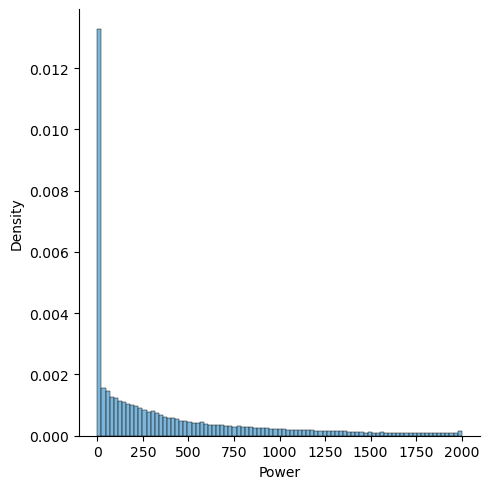

In [17]:
# display the distribution plot of Power
sns.displot(df1.Power, stat='density', color=sns.color_palette('Blues')[3])

- Observed high concentration of zero values, which may be normal since wind turbines experience several stoppages daily
- Wind speeds below the wind turbine's *cut-in* wind speed (minimum wind speed for the turbine to start generating power, typically around 3m/s) would result to zero power output
- At the location of this particular wind turbine, there is *low wind season* when wind speeds are generally low for 6 months straight
- There is also the possibility that some of these zeros are either missing data, or data errors replaced with zeros

#### WindSpeed
This is the main driver of the wind turbine's power output, and theoretically is the most significant independent variable to determine power (in meters per second).

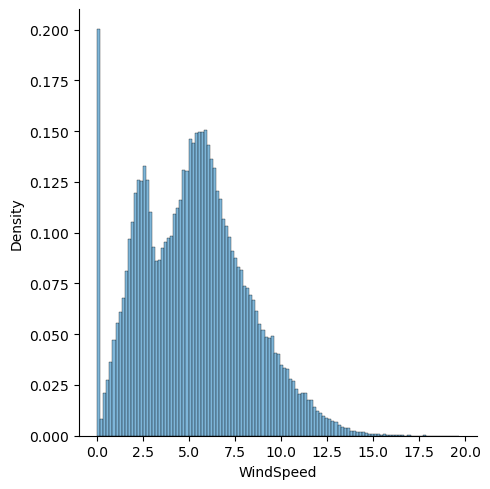

In [18]:
# display the distribution plot of WindSpeed
sns.displot(df1.WindSpeed, stat='density', color=sns.color_palette('Blues')[3])

- Similar to Power, observed high concentration of zero values as well

#### Availability
This is the percentage of time the wind turbine is able to generate at full capacity, expressed in percentage per time interval

In [19]:
# display the average availability over the time period of the data
ave_avail = df1.describe().loc["mean", "Availability"] / 100
print(str(year_start)+"-"+str(year_end)+" Average Availability = "+str(ave_avail))

2021-2023 Average Availability = 0.9323746619311116


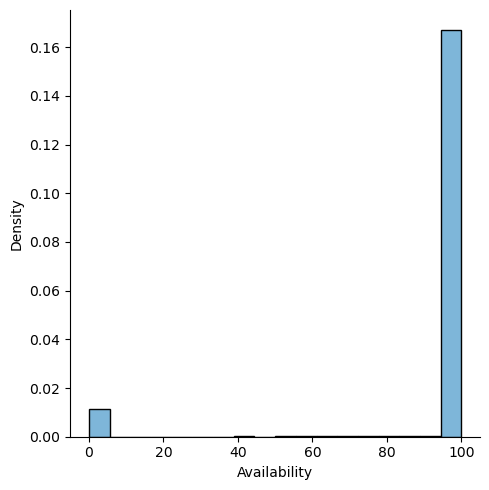

In [20]:
# display the distribution plot of Availability
sns.displot(df1.Availability, stat='density', color=sns.color_palette('Blues')[3])

- almost binary (100 or 0), with most of the values at 100

#### Summary of Univariate Analysis Observations
- Both Power and WindSpeed have high concentration of zero values
- Availability is mostly 100%. All other values are minimal other than a few zeros.

The zero values of Power seems to be more due to zero WindSpeed instead of Availability, suggesting that Availability is less significant to the Power value.

### Multivariate Analysis

#### Power vs WindSpeed

<Axes: xlabel='WindSpeed', ylabel='Power'>

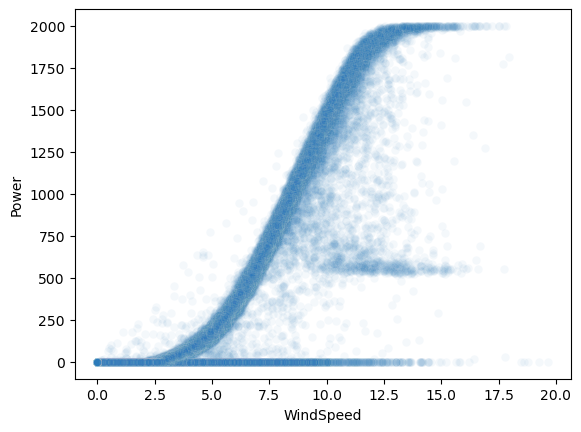

In [21]:
# display the scatterplot of Power vs WindSpeed
sns.scatterplot(x=df1.WindSpeed, y=df1.Power, alpha=0.05, color=sns.color_palette('Blues')[4])

- there is a significant number of zero power output across a large range of wind speed values
- with lower alpha (opacity), the dark point at (0, 0) suggests a high concentration of data with both Power and WindSpeed = 0

#### Power vs Availability

<Axes: xlabel='Availability', ylabel='Power'>

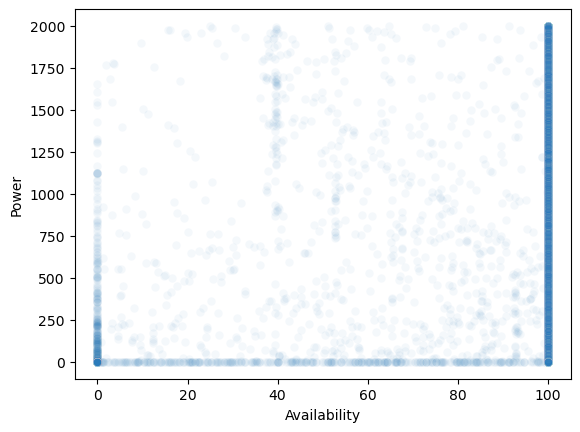

In [22]:
# display the scatterplot of Power vs Availability
sns.scatterplot(x=df1.Availability, y=df1.Power, alpha=0.05, color=sns.color_palette('Blues')[4])

- most of the data are at 100% Availability, covering the entire span of Power values
- there are also zero Power values covering the entire span of Availability values
- there is no obvious pattern

#### Summary of Multivariate Analysis Observations
- Consistent with the previous observations, the Power vs WindSpeed scatterplot shows numerous zero Power data with concentration at zero WindSpeed 
- Availability does not seem to significantly relate to the power value

Based on these observations, **drop rows with Power and WindSpeed = 0**, and **drop the Availability column** altogether.

Although zero Power, WindSpeed and Availability values are part of normal wind turbine operations, removing these may exclude or reduce influences of no-wind and unavailability to the model, making it better for its intended purpose.

In [23]:
# drop rows with WindSpeed = 0
df2 = df1.drop(df1.loc[df1.WindSpeed == 0].index)

# drop rows with Power = 0
df2 = df2.drop(df2.loc[df2.Power == 0].index)

# drop Availability column
df2 = df2.drop(["Availability"], axis=1)

# check the dimensions of the remaining dataframe
df2.shape

(95757, 10)

## 5. Outlier Detection and Removal
For the purpose of evaluating the energy generation performance of the wind turbine without external influences, outliers must be removed *(too much may result to overfitting which is not good especially for other purposes)*.

Values will be assumed outliers if they are outside the range of ***Q1 - 1.5\*IQR*** to ***Q3 + 1.5\*IQR*** (*Q1* = *1st Quartile*, *Q3* = "3rd Quartile, *IQR* = *Interquartile Range* = *Q3 - Q1*).

<sub> Reference: Donnelly, R. A., Jr. (2020). Business Statistics: A First Course (3rd ed.). Pearson. </sub>

### Splitting the Data into *Before* and *After* Improvement States
Data must first be split to avoid misclassification of actual performance difference as outliers, or *data leakage*.

Data in the *Before* improvement state covers full 1 year before the start of improvement activities, enough to capture the most recent state of the turbine before improvement.

In [24]:
df_bef = df2.copy()[(df2.index > np.datetime64(act_date_start) - np.timedelta64(365, 'D')) &
                    (df2.index <= np.datetime64(act_date_start))]

# check the dimensions of the dataframe partition before improvement
df_bef.shape

(36239, 10)

Data in the *After* improvement state starts a day after the last day of improvement activities until the most recent available data

In [25]:
df_aft = df2.copy()[df2.index > np.datetime64(act_date_end) + np.timedelta64(1, 'D')]

# check the dimensions of the dataframe partition after improvement
df_aft.shape

(28078, 10)

#### Revisitng Power vs WindSpeed
Quartiles of Power alone cannot correctly detect outliers. Instead, conditional quantiles will be used. ***Wind Power Curves*** show the relationship between the power output versus wind speed, commonly used due to the simplicity of being able to get a reasonable estimate of the energy generation of a wind turbine using only 1 parameter.

<sub> Reference: Cole, S. (n.d.). Wind Turbine Power Curve. Retrieved from https://theroundup.org/wind-turbine-power-curve/ </sub> 

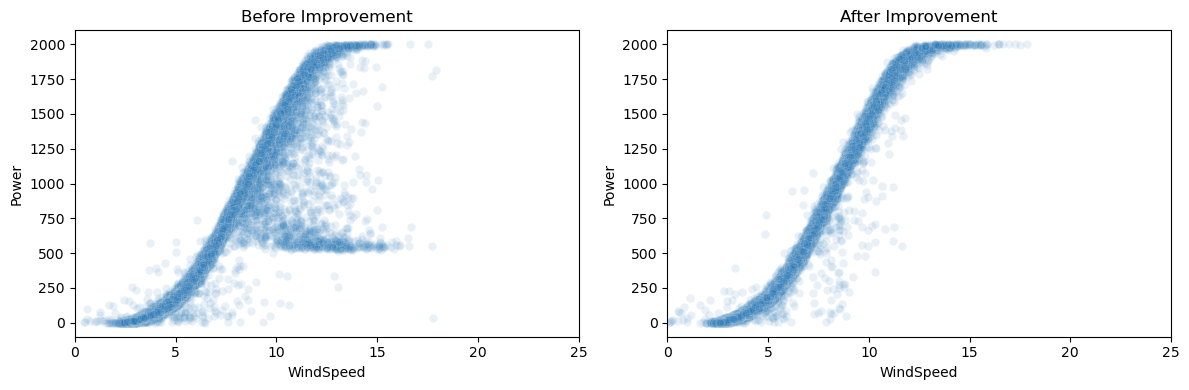

In [26]:
# plot the scatterplot of Power vs WindSpeed
plot_pc([df_bef.WindSpeed, df_aft.WindSpeed], [df_bef.Power, df_aft.Power], ["Before Improvement", "After Improvement"])

- data is concentrated to an S-shaped curve
- there are observed outliers, potentially due to power output curtailment due to grid constraints, and during ramping down of output after turbine stoppages and ramping up as the turbine stoppages were rectified

### Modelling the Power vs WindSpeed Curve to Detect Outliers with Quantile Regression
Q1 and Q3 for outlier detection will be calculated using conditional quantiles using ***Quantile Regression*** on the function modelled after the wind power curve.

It can be observed that the Power vs WindSpeed scatter plots generally concentrate on an S-shaped curve following a ***sigmoid*** function. There are several variations of the sigmoid function (e.g. *logistic function*). After plotting a variety of modified sigmoid functions over actual wind turbine scatter plots, using ***hyperbolic tangent (tanh)*** with the wind speed expressed in a ***fourth-degree polynomial*** was chosen to fit best based on visual approximation.

$$ \hat{power} = maxpower*tanh((a*windspeed+b)^4) $$

<sub> Reference: Wood, T. (n.d.). Sigmoid Function. DeepAI: Machine Learning Glossary and Terms. Retrieved from https://deepai.org/machine-learning-glossary-and-terms/sigmoid-function </sub>

In [27]:
# wind power curve sigmoid tanh equation between Power and WindSpeed defined in the Functions Module

*Quantile Regression* fits the line with the minimum total absolute errors with weights based on the chosen quantile, unlike linear regression which is just based on the ordinary least square error. Using quantiles, extreme values have less impact on quantile regression.

The error function is given by:

$$
\begin{equation}
  \epsilon =
    \begin{cases}
      q * (power - \hat{power}) & \text{if $ (power - \hat{power}) \ge 0$}\\
      (q-1) * (power - \hat{power}) & \text{if $ (power - \hat{power}) < 0$ }\\
    \end{cases}       
\end{equation}
$$

<sub> Reference: Koenker, R., & Hallock, K. F. (2001). Quantile Regression. *Journal of Economic Perspectives*, 15(4), 143-156. </sub>

In [28]:
# quantile regression error function defined in the Functions Module

# initial guesses for the parameters (trial-and-error with visual approximation)
init_guess = [0.088, 0.2]

# quantile values for calculation of outlier detection range
quantiles = [25, 75]

Solve for the optimized parameters by minimizing the error function results.

<sub> Reference: Brownlee, J. (2021, February 8). Function Optimization with SciPy. Machine Learning Mastery. Retrieved from https://machinelearningmastery.com/function-optimization-with-scipy/ </sub>

In [29]:
# initialize arrays to store the optimized parameters (+2 rows because the median and ols will be added later during Regression)
opt_params_bef = np.zeros((len(quantiles)+2, len(init_guess)))
opt_params_aft = np.zeros((len(quantiles)+2, len(init_guess)))

# minimize the error function of the tanh function for each quartile
for i, q in enumerate(quantiles):
    np.random.seed(42)
    q_perc = float(q)/100
    result_bef = minimize(err_function_qr, init_guess, args=(df_bef.WindSpeed, df_bef.Power, q_perc))
    result_aft = minimize(err_function_qr, init_guess, args=(df_aft.WindSpeed, df_aft.Power, q_perc))
    opt_params_bef[i] = result_bef.x
    opt_params_aft[i] = result_aft.x

In [30]:
# coefficients of the regression lines
pd.DataFrame({'Quantile': quantiles,
              'a (Before)': opt_params_bef[:len(quantiles),0],
              'b (Before)': opt_params_bef[:len(quantiles),1],
              'a (After)': opt_params_aft[:len(quantiles),0],
              'b (After)': opt_params_aft[:len(quantiles),1]}).style.hide(axis="index")

Quantile,a (Before),b (Before),a (After),b (After)
25,0.086361,0.107535,0.087711,0.111165
75,0.087074,0.126043,0.087332,0.132685


In [31]:
# create a dataframe of the quantile regression power curves for a sequence of wind speed values for visualization

# assume maximum wind speed of 25m/s
ws_max = 25
# increments in wind speed value (m/s)
inc = 0.1

# create dataframes using custom function from the Functions Module
df_bef_pc = create_pc_df("WindSpeed", 0, ws_max, inc)
df_aft_pc = create_pc_df("WindSpeed", 0, ws_max, inc)

In [32]:
# fit the sequence of wind speed values to the quantile regression model for the different quantiles 
qname = "q"
for i, q in enumerate(quantiles):
    df_bef_pc.loc[:, qname+str(q)] = wpc_equation(opt_params_bef[i], df_bef_pc.WindSpeed)
    df_aft_pc.loc[:, qname+str(q)] = wpc_equation(opt_params_aft[i], df_aft_pc.WindSpeed)
    
# upper and lower bounds of the range for filtering outliers are calculated with a custom function from the Functions Module 
# set tolerance value (plus/minus 1.5%)
tolerance = 0.015
df_bef_pc.loc[:, qname+"25-1.5IQR"] = outlier_pc(df_bef_pc, tolerance=tolerance)[0]
df_bef_pc.loc[:, qname+"75+1.5IQR"] = outlier_pc(df_bef_pc, tolerance=tolerance)[1]
df_aft_pc.loc[:, qname+"25-1.5IQR"] = outlier_pc(df_aft_pc, tolerance=tolerance)[0]
df_aft_pc.loc[:, qname+"75+1.5IQR"] = outlier_pc(df_aft_pc, tolerance=tolerance)[1]

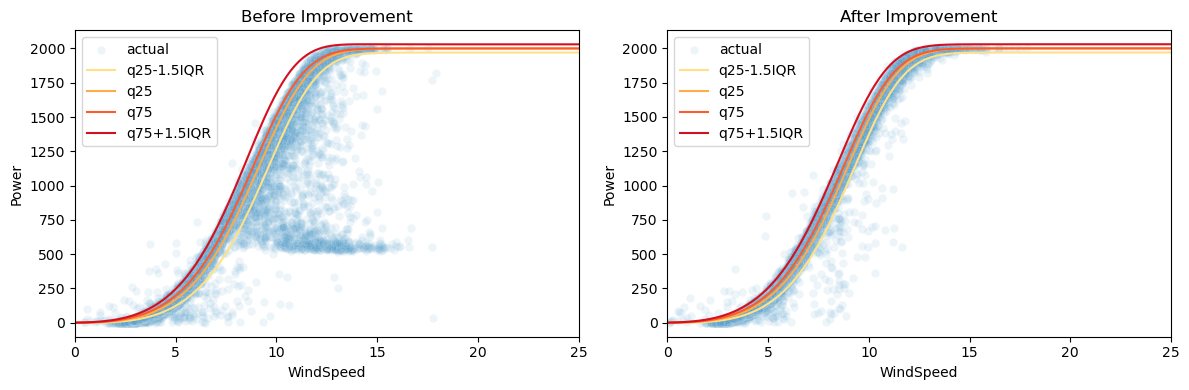

In [33]:
# plot the scatterplot of Power vs WindSpeed and lineplots of the quantile regression lines
plot_pc([df_bef.WindSpeed, df_aft.WindSpeed], [df_bef.Power, df_aft.Power], ["Before Improvement", "After Improvement"], 
        [df_bef_pc.WindSpeed, df_aft_pc.WindSpeed], [df_bef_pc, df_aft_pc], 
        [qname+"25-1.5IQR", qname+"25", qname+"75", qname+"75+1.5IQR"], blue_index=3)

### Filtering Outliers

In [34]:
# create a subset dataframe with only the rows with Power values within the chosen quantile range
# upper and lower bounds of the range for filtering outliers are calculated with a custom function from the Functions Module
df_bef_cleaned = df_bef[(df_bef.Power >= outlier_filter_range(df_bef.WindSpeed, tolerance=tolerance)[0]) & 
                        (df_bef.Power <= outlier_filter_range(df_bef.WindSpeed, tolerance=tolerance)[1])]
print("Before Improvement Data row count: " + str(len(df_bef_cleaned)))

df_aft_cleaned = df_aft[(df_aft.Power >= outlier_filter_range(df_aft.WindSpeed, tolerance=tolerance)[0]) & 
                        (df_aft.Power <= outlier_filter_range(df_aft.WindSpeed, tolerance=tolerance)[1])]
print("After Improvement Data row count: " + str(len(df_aft_cleaned)))

Before Improvement Data row count: 31248
After Improvement Data row count: 26218


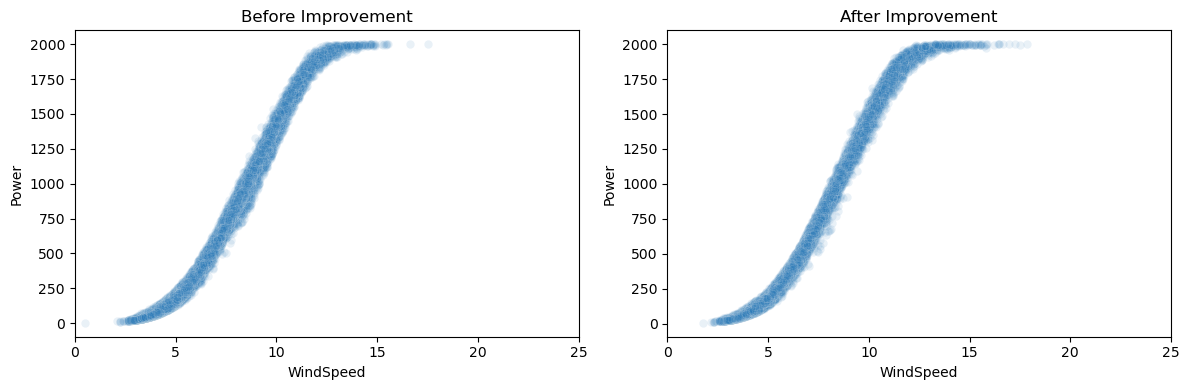

In [35]:
# plot the updated scatterplot of Power vs WindSpeed after removing outliers
plot_pc([df_bef_cleaned.WindSpeed, df_aft_cleaned.WindSpeed],
        [df_bef_cleaned.Power, df_aft_cleaned.Power], ["Before Improvement", "After Improvement"])

## 6. Regression
To compare the turbine performance before and after improvement on equal grounds, Power needs to be modeled. Various regression techniques will be employed and the most accurate model will be selected.

#### Data Preparation

In [36]:
# split the target and features

# before improvement
y_bef = df_bef_cleaned.Power
x_bef = df_bef_cleaned.drop(["Power"], axis=1)

# after improvement
y_aft = df_aft_cleaned.Power
x_aft = df_aft_cleaned.drop(["Power"], axis=1)

In [37]:
# split the data to training and test sets
x_bef_train, x_bef_test, y_bef_train, y_bef_test = train_test_split(x_bef, y_bef, test_size=0.2, random_state=42)
x_aft_train, x_aft_test, y_aft_train, y_aft_test = train_test_split(x_aft, y_aft, test_size=0.2, random_state=42)

In [38]:
# create empty placeholder lists for the results
names = []
r2_bef = []
rmse_bef = []
r2_aft = []
rmse_aft = []
multi_feat_bef = []
multi_feat_aft = []

### 6.1. Regression With Only Wind Speed as the Feature
Following the concept of wind power curves and with wind speed thoretically being the most significant driver of turbine power output, this section aims to fit the data to a representative wind power curve With only WindSpeed as the sole feature using various regression techniques. *Feature Scaling* and *Feature Selection* will be skipped.

#### Sigmoid Function Regression
The sigmoid function used in outlier detection will be used instead of linear regression. Quantile regression for the 50th quantile (median) will be used. Since the function and its optimization was custom-made, this will be done outside the loop of the other models that use *.fit()* and *.predict()*.

In [39]:
# minimize the errors of the 50th quantile (median)
q_perc = 50/100
np.random.seed(42)
result_bef = minimize(err_function_qr, init_guess, args=(x_bef_train.WindSpeed, y_bef_train, q_perc))
result_aft = minimize(err_function_qr, init_guess, args=(x_aft_train.WindSpeed, y_aft_train, q_perc))

# append parameters to the array used in outlier detection
opt_params_bef[len(quantiles)] = result_bef.x
opt_params_aft[len(quantiles)] = result_aft.x

# coefficients
print("Sigmoid Regression Coefficients (50th Quantile Regression)")
print("Before improvement: " + str(opt_params_bef[len(quantiles)]))
print("After improvement: " + str(opt_params_aft[len(quantiles)]))

Sigmoid Regression Coefficients (50th Quantile Regression)
Before improvement: [0.08738713 0.11517263]
After improvement: [0.08707413 0.12590901]


In [40]:
# evaluate the accuracy of the model
names.append("Sigmoid 50th Quantile Reg (WS only)")

y_bef_pred = wpc_equation(opt_params_bef[len(quantiles)], x_bef_test.WindSpeed)
r2_bef.append(r2_score(y_bef_test, y_bef_pred))
rmse_bef.append(mean_squared_error(y_bef_test, y_bef_pred, squared=False))
multi_feat_bef.append(False)

y_aft_pred = wpc_equation(opt_params_aft[len(quantiles)], x_aft_test.WindSpeed)
r2_aft.append(r2_score(y_aft_test, y_aft_pred))
rmse_aft.append(mean_squared_error(y_aft_test, y_aft_pred, squared=False))
multi_feat_aft.append(False)

# also fit the sequence of wind speed values to the sigmoid function regression model to create the power curve
df_bef_pc.loc[:, "PC_sig_q50"] = wpc_equation(opt_params_bef[len(quantiles)], df_bef_pc.WindSpeed)
df_aft_pc.loc[:, "PC_sig_q50"] = wpc_equation(opt_params_aft[len(quantiles)], df_aft_pc.WindSpeed)

In addition to the 50th quantile (median), it is also worth trying optimizing based on *Ordinary Least Squares (OLS)* which is typically used in linear regression

In [41]:
# minimize the OLS errors
# OLS error function defined in the Functions Module
np.random.seed(42)
result_bef = minimize(err_function_ols, init_guess, args=(x_bef_train.WindSpeed, y_bef_train))
result_aft = minimize(err_function_ols, init_guess, args=(x_aft_train.WindSpeed, y_aft_train))

# append parameters to the array used in outlier detection
opt_params_bef[len(quantiles)+1] = result_bef.x
opt_params_aft[len(quantiles)+1] = result_aft.x

# coefficients
print("Sigmoid Regression Coefficients (Ordinary Least Squares)")
print("Before improvement: " + str(opt_params_bef[len(quantiles)+1]))
print("After improvement: " + str(opt_params_aft[len(quantiles)+1]))

Sigmoid Regression Coefficients (Ordinary Least Squares)
Before improvement: [-0.08500948 -0.13273015]
After improvement: [0.08576898 0.13644981]


In [42]:
# evaluate the accuracy of the model
names.append("Sigmoid OLS Reg (WS only)")

y_bef_pred = wpc_equation(opt_params_bef[len(quantiles)+1], x_bef_test.WindSpeed)
r2_bef.append(r2_score(y_bef_test, y_bef_pred))
rmse_bef.append(mean_squared_error(y_bef_test, y_bef_pred, squared=False))
multi_feat_bef.append(False)

y_aft_pred = wpc_equation(opt_params_aft[len(quantiles)+1], x_aft_test.WindSpeed)
r2_aft.append(r2_score(y_aft_test, y_aft_pred))
rmse_aft.append(mean_squared_error(y_aft_test, y_aft_pred, squared=False))
multi_feat_aft.append(False)

# also fit the sequence of wind speed values to the sigmoid function regression model to create the power curve
df_bef_pc.loc[:, "PC_sig_ols"] = wpc_equation(opt_params_bef[len(quantiles)+1], df_bef_pc.WindSpeed)
df_aft_pc.loc[:, "PC_sig_ols"] = wpc_equation(opt_params_aft[len(quantiles)+1], df_aft_pc.WindSpeed)

#### Using Other Regression Techniques with Only WindSpeed as the Feature

In [43]:
# preparing data for looping through the different techniques
long_names = ["Decision Tree Regressor",
              "Random Forest Regressor",
              "GradientBoosting Regressor",
              "AdaBoost Regressor",
              "XGBoost Regressor",
              "CatBoost Regressor",
              "LightGBM Regressor",
              "SGD Regressor",
              "Artificial Neural Network"]

short_names = ["dt", "rf", "gb", "ada", "xgb", "cat", "lgbm", "sgd", "ann"]

# create instances of the models
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()
ada = AdaBoostRegressor()
xgb = XGBRegressor()
cat = CatBoostRegressor(verbose=False)
lgbm = LGBMRegressor()
sgd = SGDRegressor(max_iter=1000)
ann = MLPRegressor(hidden_layer_sizes=(10, 5), learning_rate_init=0.01, max_iter=1000, random_state=42)

# list of model instances
models = [dt, rf, gb, ada, xgb, cat, lgbm, sgd, ann]

In [44]:
# having only 1 feature, the x arrays need to be reshaped
x_bef_train_ws = x_bef_train.WindSpeed.values.reshape(-1,1)
x_bef_test_ws = x_bef_test.WindSpeed.values.reshape(-1,1)
x_aft_train_ws = x_aft_train.WindSpeed.values.reshape(-1,1)
x_aft_test_ws = x_aft_test.WindSpeed.values.reshape(-1,1)

In [45]:
# iterate through the various regression models
for model, l_name, s_name in zip(models, long_names, short_names):
    names.append(l_name + " (WS Only)")
    np.random.seed(42)
    
    model_bef = clone(model)
    model_bef.fit(x_bef_train_ws, y_bef_train)
    y_bef_pred = model_bef.predict(x_bef_test_ws)
    r2_bef.append(model_bef.score(x_bef_test_ws, y_bef_test))
    rmse_bef.append(mean_squared_error(y_bef_test, y_bef_pred, squared=False))
    multi_feat_bef.append(False)
    # power curve
    df_bef_pc.loc[:, "PC_"+s_name] = model_bef.predict(df_bef_pc.WindSpeed.values.reshape(-1,1))
    
    model_aft = clone(model)
    model_aft.fit(x_aft_train_ws, y_aft_train)
    y_aft_pred = model_aft.predict(x_aft_test_ws)
    r2_aft.append(model_aft.score(x_aft_test_ws, y_aft_test))
    rmse_aft.append(mean_squared_error(y_aft_test, y_aft_pred, squared=False))
    multi_feat_aft.append(False)
    # power curve
    df_aft_pc.loc[:, "PC_"+s_name] = model_aft.predict(df_aft_pc.WindSpeed.values.reshape(-1,1))

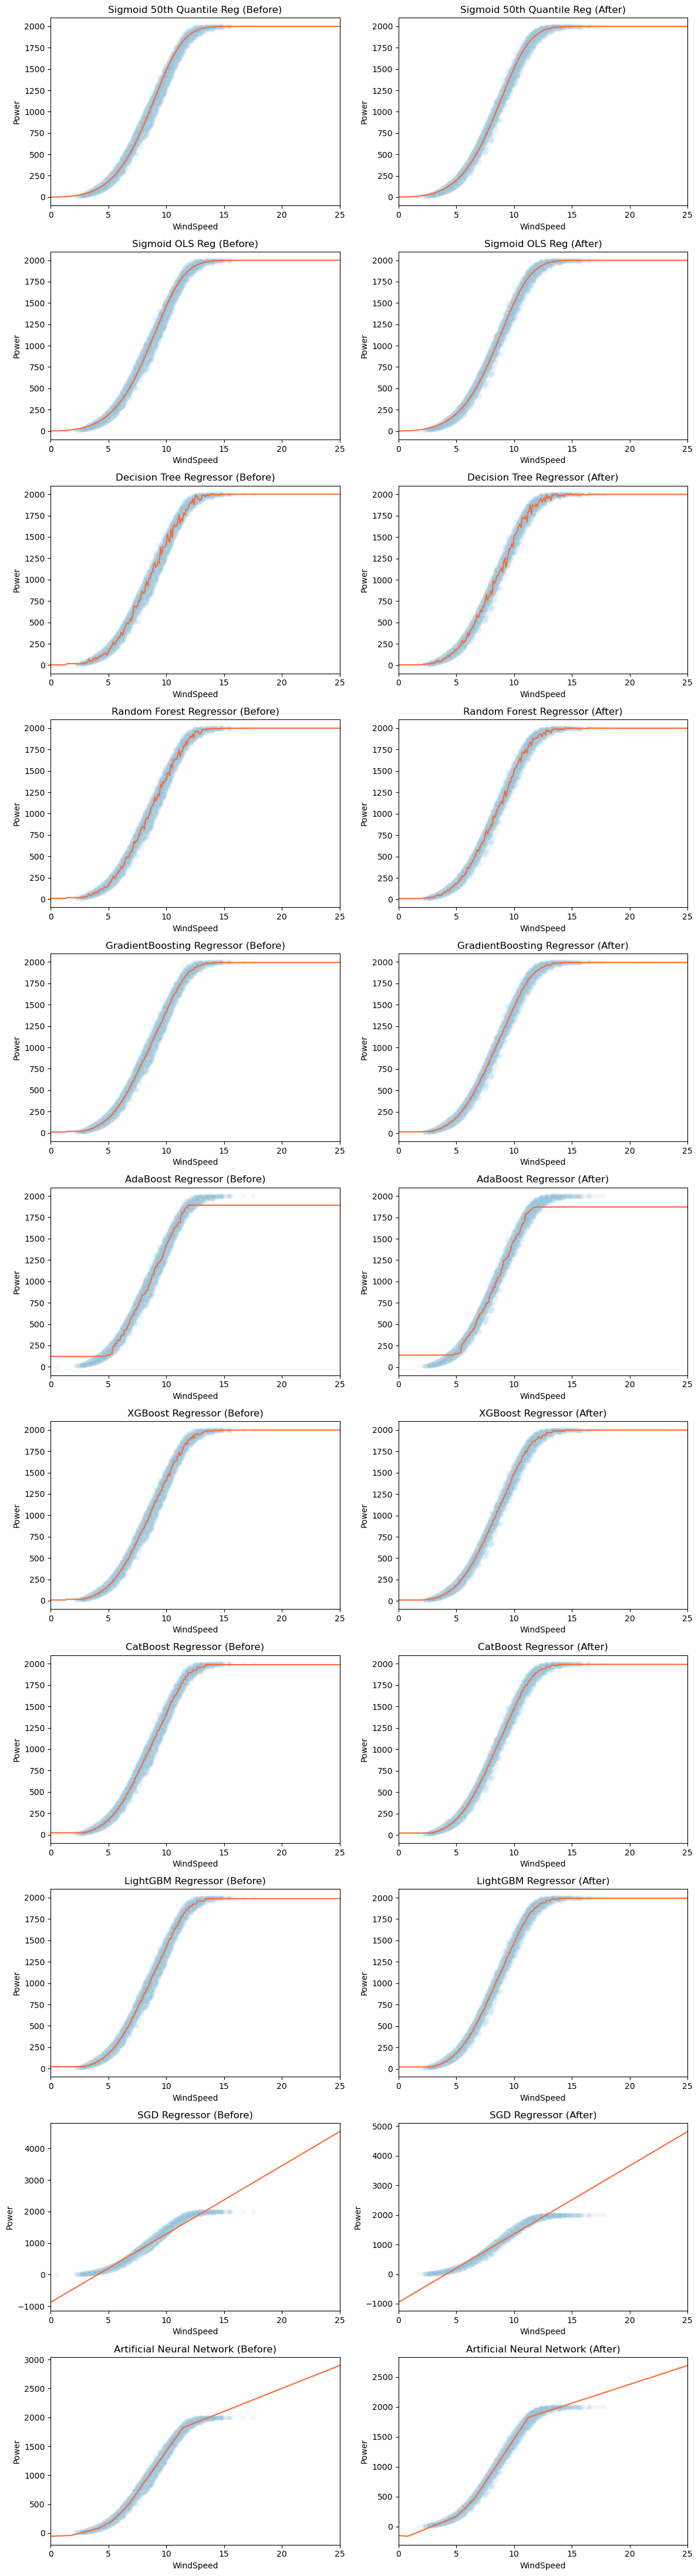

In [46]:
# plot the scatterplot of Power vs WindSpeed and the resulting power curves from the models

# lists for plotting
plot_scatter_x = []
plot_scatter_y = []
plot_titles = []
plot_pc_x = []
plot_pc_y = []
for l_name, s_name in zip(["Sigmoid 50th Quantile Reg", "Sigmoid OLS Reg"]+long_names, ["sig_q50", "sig_ols"]+short_names):
    for i in range(2):
        plot_scatter_x.append(df_bef_cleaned.WindSpeed if i%2 == 0 else df_aft_cleaned.WindSpeed)
        plot_scatter_y.append(df_bef_cleaned.Power if i%2 == 0 else df_aft_cleaned.Power)
        plot_titles.append(l_name + (" (Before)" if i%2 == 0 else " (After)"))
        plot_pc_x.append(df_bef_pc.WindSpeed if i%2 == 0 else df_aft_pc.WindSpeed)
        plot_pc_y.append(df_bef_pc["PC_"+s_name] if i%2 == 0 else df_aft_pc["PC_"+s_name])

plot_pc(plot_scatter_x, plot_scatter_y, plot_titles, plot_pc_x, plot_pc_y, blue_index=2)

# clear lists to save memory
plot_scatter_x = []
plot_scatter_y = []
plot_titles = []
plot_pc_x = []
plot_pc_y = []

### 6.2. Regression With Multiple Features
This could have been executed using *Pipelines* which include *Feature Scaling*, *Feature Selection*, and *Modelling* for each regression technique. However, for faster processing, *Feature Scaling* and *Feature Selection* were done only once outside the loop, and a normal loop through the models was used instead of a *Pipeline*.

#### Feature Scaling

In [47]:
rs = StandardScaler()

rs.fit(x_bef_train)
x_bef_train_scaled = pd.DataFrame(rs.transform(x_bef_train), columns=x_bef_train.columns)
x_bef_test_scaled = pd.DataFrame(rs.transform(x_bef_test), columns=x_bef_test.columns)

rs.fit(x_aft_train)
x_aft_train_scaled = pd.DataFrame(rs.transform(x_aft_train), columns=x_aft_train.columns)
x_aft_test_scaled = pd.DataFrame(rs.transform(x_aft_test), columns=x_aft_test.columns)

#### Feature Selection

Using ***SelectFromModel*** with RandomForestRegressor estimator

In [48]:
select = SelectFromModel(RandomForestRegressor(n_estimators = 100, random_state=42))

select.fit(x_bef_train_scaled, y_bef_train)
x_bef_train_sel = x_bef_train_scaled.copy().loc[:,select.get_support()]
x_bef_test_sel = x_bef_test_scaled.copy().loc[:,select.get_support()]
print("Before Improvement Features: " + str(x_bef_train_scaled.columns[select.get_support()].values))

select.fit(x_aft_train_scaled, y_aft_train)
x_aft_train_sel = x_aft_train_scaled.copy().loc[:,select.get_support()]
x_aft_test_sel = x_aft_test_scaled.copy().loc[:,select.get_support()]
print("After Improvement Features: " + str(x_aft_train_scaled.columns[select.get_support()].values))

Before Improvement Features: ['WindSpeed']
After Improvement Features: ['WindSpeed']


*SelectFromModel* selects only WindSpeed, which just goes back to a wind power curve, supporting the idea that wind speed is the most significant feature to predict the power output of a wind turbine, and other parameters are of low significance.

Try ***SelectKBest*** to force multiple features.

In [49]:
select = SelectKBest(score_func=f_regression, k=4)

select.fit(x_bef_train_scaled, y_bef_train)
x_bef_train_sel = x_bef_train_scaled.copy().loc[:,select.get_support()]
x_bef_test_sel = x_bef_test_scaled.copy().loc[:,select.get_support()]
print("Before Improvement Features: " + str(x_bef_train_scaled.columns[select.get_support()].values))

select.fit(x_aft_train_scaled, y_aft_train)
x_aft_train_sel = x_aft_train_scaled.copy().loc[:,select.get_support()]
x_aft_test_sel = x_aft_test_scaled.copy().loc[:,select.get_support()]
print("After Improvement Features: " + str(x_aft_train_scaled.columns[select.get_support()].values))

Before Improvement Features: ['WindSpeed' 'GeneratorTemp' 'GeneratorRPM' 'PowerFactor']
After Improvement Features: ['WindSpeed' 'GeneratorTemp' 'GeneratorRPM' 'PowerFactor']


#### Multiple Regression

In [50]:
# iterate through the various regression models
# (skip the sigmoid function regressions because these were based on power curves with only 1 feature)
for model, l_name, s_name in zip(models, long_names, short_names):
    names.append(l_name + " (multi feat)")
    np.random.seed(42)
    
    model_bef = clone(model)
    model_bef.fit(x_bef_train_sel, y_bef_train)
    y_bef_pred = model_bef.predict(x_bef_test_sel)
    r2_bef.append(model_bef.score(x_bef_test_sel, y_bef_test))
    rmse_bef.append(mean_squared_error(y_bef_test, y_bef_pred, squared=False))
    multi_feat_bef.append(True)
    
    model_aft = clone(model)
    model_aft.fit(x_aft_train_sel, y_aft_train)
    y_aft_pred = model_aft.predict(x_aft_test_sel)
    r2_aft.append(model_aft.score(x_aft_test_sel, y_aft_test))
    rmse_aft.append(mean_squared_error(y_aft_test, y_aft_pred, squared=False))
    multi_feat_aft.append(True)

### Regression Results

#### Before Improvement

In [51]:
# create a dataframe summarizing the results of all regression models on the Before improvement dataset
results_bef = pd.DataFrame(zip(names, multi_feat_bef, r2_bef, rmse_bef), 
                           columns=['Model', 'Multi_Feature', 'R2', 'RMSE'])

# based on R2
#results_bef.sort_values(by=['R2', 'RMSE'], ascending=[False, True]).style.hide(axis="index")
# based on RMSE
results_bef_sort = results_bef.sort_values(by=['RMSE', 'R2'], ascending=[True, False])
results_bef_sort.style.hide(axis="index")

Model,Multi_Feature,R2,RMSE
LightGBM Regressor (multi feat),True,0.997306,23.923363
CatBoost Regressor (multi feat),True,0.997256,24.146989
XGBoost Regressor (multi feat),True,0.997161,24.562579
GradientBoosting Regressor (multi feat),True,0.997075,24.928681
Random Forest Regressor (multi feat),True,0.997073,24.936553
Artificial Neural Network (multi feat),True,0.996661,26.636213
GradientBoosting Regressor (WS Only),False,0.995697,30.237703
LightGBM Regressor (WS Only),False,0.995685,30.279317
CatBoost Regressor (WS Only),False,0.995662,30.359206
Artificial Neural Network (WS Only),False,0.995521,30.849506


#### After Improvement

In [52]:
# create a dataframe summarizing the results of all regression models on the After improvement dataset
results_aft = pd.DataFrame(zip(names, multi_feat_aft, r2_aft, rmse_aft), 
                           columns=['Model', 'Multi_Feature', 'R2', 'RMSE'])

# based on R2
#results_aft.sort_values(by=['R2', 'RMSE'], ascending=[False, True]).style.hide(axis="index")
# based on RMSE
results_aft_sort = results_aft.sort_values(by=['RMSE', 'R2'], ascending=[True, False])
results_aft_sort.style.hide(axis="index")

Model,Multi_Feature,R2,RMSE
CatBoost Regressor (multi feat),True,0.997773,24.582520
LightGBM Regressor (multi feat),True,0.997658,25.208387
XGBoost Regressor (multi feat),True,0.997573,25.663014
GradientBoosting Regressor (multi feat),True,0.997538,25.849472
Random Forest Regressor (multi feat),True,0.997535,25.865920
Artificial Neural Network (multi feat),True,0.997128,27.917833
LightGBM Regressor (WS Only),False,0.996439,31.085111
CatBoost Regressor (WS Only),False,0.996431,31.122609
GradientBoosting Regressor (WS Only),False,0.996418,31.177286
XGBoost Regressor (WS Only),False,0.996304,31.672328


## 7. Selecting the Best Model

#### Regression Results Observations and Interpretation
- All models have a high accuracy scores (high R2 and low RMSE)
- Although high accuracy may have been due to outlier removal, this was deliberately done to isolate the improvement in energy generation performance
- The improvement in using multiple features over using only wind speed is not too significant

Based on these observations, the best model will be chosen from the single-feature models (with *only WindSpeed*) due to the following:
- to simplify the model and enable the usability of wind power curves to simplify the quantification of the turbine performance improvement by requiring only wind speed.
- minimal accuracy gains versus the added complexity of having more features of multi-feature models

In [53]:
# get the index of the model with the highest accuracy score

# based on R2
#best_index_bef = results_bef[results_bef['R2'] == results_bef[results_bef['Multi_Feature'] == False]['R2'].max()].index.values[0]
#best_index_aft = results_aft[results_aft['R2'] == results_aft[results_aft['Multi_Feature'] == False]['R2'].max()].index.values[0]

# based on RMSE
best_index_bef = results_bef[results_bef['RMSE'] == results_bef[results_bef['Multi_Feature'] == False]['RMSE'].min()].index.values[0]
best_index_aft = results_aft[results_aft['RMSE'] == results_aft[results_aft['Multi_Feature'] == False]['RMSE'].min()].index.values[0]

print("Best Model (Before Improvement): " + results_bef.Model[best_index_bef] + 
      ", RMSE = " + str(round(results_bef.RMSE[best_index_bef],2)))
print("Best Model (After Improvement): " + results_aft.Model[best_index_aft] + 
      ", RMSE = " + str(round(results_aft.RMSE[best_index_aft],2)))

Best Model (Before Improvement): GradientBoosting Regressor (WS Only), RMSE = 30.24
Best Model (After Improvement): LightGBM Regressor (WS Only), RMSE = 31.09


In [54]:
# refitting the best model

# since the first 2 models were custom-defined, and the coefficients are already saved, refitting is not applicable
if best_index_bef > 1:
    # not Sigmoid 50th Quantile and OLS Reg
    np.random.seed(42)
    model_bef = clone(models[best_index_bef - 2])
    model_bef.fit(x_bef_train_ws, y_bef_train)
    
if best_index_aft > 1:
    # not Sigmoid 50th Quantile and OLS Reg
    np.random.seed(42)
    model_aft = clone(models[best_index_aft - 2])
    model_aft.fit(x_aft_train_ws, y_aft_train)

### Out-of-Sample Predictions

In [55]:
# take the data prior to the Before Improvement period
# use df2 (after rows with zero power values were removed) to save some data cleaning
df_oos = df2.copy()[df2.index <= np.datetime64(act_date_start) - np.timedelta64(365, 'D')]
print("Out-of-Sample Data row count: " + str(len(df_oos)))

Out-of-Sample Data row count: 29477


<Axes: xlabel='WindSpeed', ylabel='Power'>

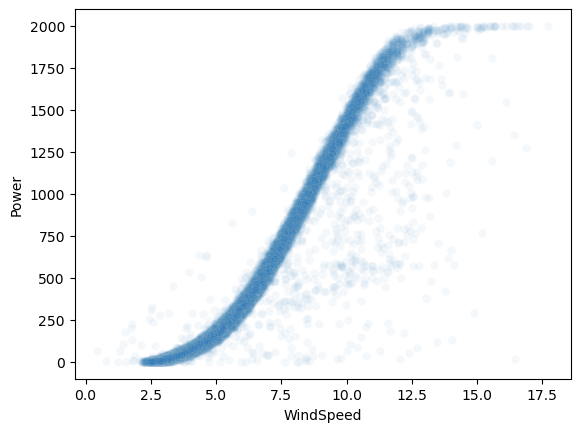

In [56]:
# display the scatterplot of the Out-of-Sample Power vs WindSpeed
sns.scatterplot(x=df_oos.WindSpeed, y=df_oos.Power, alpha=0.05, color=sns.color_palette('Blues')[4])

- has outliers, simulating how new unseen data will be like.

The best models will first be tested on the unfiltered out-of-sample data to simulate the model performance on new unseen data.

There is no available Out-of-Sample (OoS) data for the *After* improvement state to maximize training datafrom the limited available data. An OoS test can be done on the *After* improvement state once more data is available. Because of this, it is expected that the *After* improvement model will be less accurate than the *Before* improvement model accounting for the performance differences.

In [57]:
# predicting Power using the unfiltered OoS data on the best model

if best_index_bef == 0:
    # Sigmoid 50th Quantile Reg
    y_oos_bef_pred = wpc_equation(opt_params_bef[len(quantiles)], df_oos.WindSpeed.values.reshape(-1,1))
elif best_index_bef == 1:
    # Sigmoid OLS Reg
    y_oos_bef_pred = wpc_equation(opt_params_bef[len(quantiles)+1], df_oos.WindSpeed.values.reshape(-1,1))
else:
    # other reg
    y_oos_bef_pred = model_bef.predict(df_oos.WindSpeed.values.reshape(-1,1))
    
if best_index_aft == 0:
    # Sigmoid 50th Quantile Reg
    y_oos_aft_pred = wpc_equation(opt_params_aft[len(quantiles)], df_oos.WindSpeed.values.reshape(-1,1))
elif best_index_aft == 1:
    # Sigmoid OLS Reg
    y_oos_aft_pred = wpc_equation(opt_params_aft[len(quantiles)+1], df_oos.WindSpeed.values.reshape(-1,1))
else:
    # other reg
    y_oos_aft_pred = model_aft.predict(df_oos.WindSpeed.values.reshape(-1,1))

# in case of negative values, replace with zero
y_oos_bef_pred[y_oos_bef_pred < 0] = 0
y_oos_aft_pred[y_oos_aft_pred < 0] = 0

# evaluate the accuracy of the OoS prediction
r2_bef = r2_score(df_oos.Power, y_oos_bef_pred)
rmse_bef = mean_squared_error(df_oos.Power, y_oos_bef_pred, squared=False)
r2_aft = r2_score(df_oos.Power, y_oos_aft_pred)
rmse_aft = mean_squared_error(df_oos.Power, y_oos_aft_pred, squared=False)
pd.DataFrame({'Before Improvement': [r2_bef, rmse_bef], 'After Improvement': [r2_aft, rmse_aft]}, index=['R2', 'RMSE'])

,Before Improvement,After Improvement
R2,0.950695,0.944656
RMSE,102.610446,108.712963


Although these accuracy scores are not low, it is still worse than the model accuracy scores on the test data due to the outliers.

For the purpose of this project to isolate other factors that may affect the generation such as stoppages and grid curtailment, an OoS prediction will also be done with cleaned OoS data. Since the OoS data period is just before the Before Improvement period, it can be assumed that the outlier removal method used for the Before Improvement dataset is also applicable to the OoS data. 

In [58]:
# create a subset dataframe with only the rows with Power values within the chosen quantile range
df_oos_cleaned = df_oos[(df_oos.Power >= outlier_filter_range(df_oos.WindSpeed, tolerance=tolerance)[0]) & 
                        (df_oos.Power <= outlier_filter_range(df_oos.WindSpeed, tolerance=tolerance)[1])]
print("Out-of-Sample Data row count (no outliers): " + str(len(df_oos_cleaned)))

Out-of-Sample Data row count (no outliers): 25767


<Axes: xlabel='WindSpeed', ylabel='Power'>

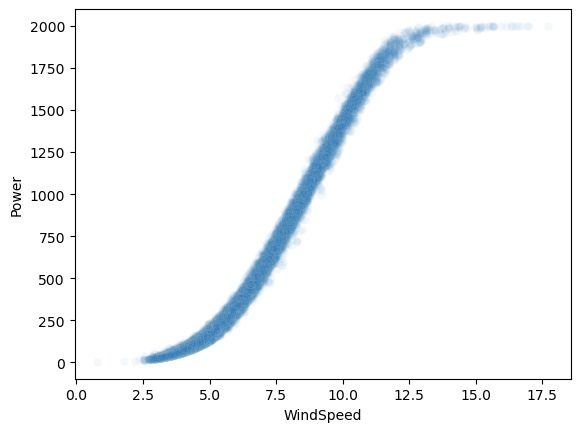

In [59]:
# display the scatterplot of the cleaned OoS Power vs WindSpeed
sns.scatterplot(x=df_oos_cleaned.WindSpeed, y=df_oos_cleaned.Power, alpha=0.05, color=sns.color_palette('Blues')[4])

In [60]:
# predicting Power using the cleaned OoS data on the best model

if best_index_bef == 0:
    # Sigmoid 50th Quantile Reg
    y_oos_cleaned_bef_pred = wpc_equation(opt_params_bef[len(quantiles)], df_oos_cleaned.WindSpeed.values.reshape(-1,1))
elif best_index_bef == 1:
    # Sigmoid OLS Reg
    y_oos_cleaned_bef_pred = wpc_equation(opt_params_bef[len(quantiles)+1], df_oos_cleaned.WindSpeed.values.reshape(-1,1))
else:
    # other reg
    y_oos_cleaned_bef_pred = model_bef.predict(df_oos_cleaned.WindSpeed.values.reshape(-1,1))
    
if best_index_aft == 0:
    # Sigmoid 50th Quantile Reg
    y_oos_cleaned_aft_pred = wpc_equation(opt_params_aft[len(quantiles)], df_oos_cleaned.WindSpeed.values.reshape(-1,1))
elif best_index_aft == 1:
    # Sigmoid OLS Reg
    y_oos_cleaned_aft_pred = wpc_equation(opt_params_aft[len(quantiles)+1], df_oos_cleaned.WindSpeed.values.reshape(-1,1))
else:
    # other reg
    y_oos_cleaned_aft_pred = model_aft.predict(df_oos_cleaned.WindSpeed.values.reshape(-1,1))

# in case of negative values, replace with zero
y_oos_cleaned_bef_pred[y_oos_cleaned_bef_pred < 0] = 0
y_oos_cleaned_aft_pred[y_oos_cleaned_aft_pred < 0] = 0

# evaluate the accuracy of the OoS prediction
r2_bef = r2_score(df_oos_cleaned.Power, y_oos_cleaned_bef_pred)
rmse_bef = mean_squared_error(df_oos_cleaned.Power, y_oos_cleaned_bef_pred, squared=False)
r2_aft = r2_score(df_oos_cleaned.Power, y_oos_cleaned_aft_pred)
rmse_aft = mean_squared_error(df_oos_cleaned.Power, y_oos_cleaned_aft_pred, squared=False)
pd.DataFrame({'Before Improvement': [r2_bef, rmse_bef], 'After Improvement': [r2_aft, rmse_aft]}, index=['R2', 'RMSE'])

,Before Improvement,After Improvement
R2,0.995688,0.992599
RMSE,30.055872,39.375453


OoS prediction using the best model still showed high accuracy scores, with the expected relatively lower accuracy on the *After Improvement* model.

## 8. Evaluating the Performance Improvement of the Wind Turbine

### Analyze the Distribution of Historical Wind Speed Data
To quantify the turbine performance improvement in terms of *Annual Energy Production (AEP)*, a representation of an annual wind speed profile is needed to predict the energy generation using the models.

In [61]:
# take the most recent FULL YEARS of wind speed data available from the imported data
# (e.g. if 2023 data ends in July and full 2021-2022 data are imported, start from July 2021 instead of January 2021)

# use df1 (before rows with zero power values were removed) to see the actual distribution of the wind speed data
ws = df1.copy().loc[df1.index > df1.index.max() - np.timedelta64(365 * (year_end - year_start), 'D'), "WindSpeed"]

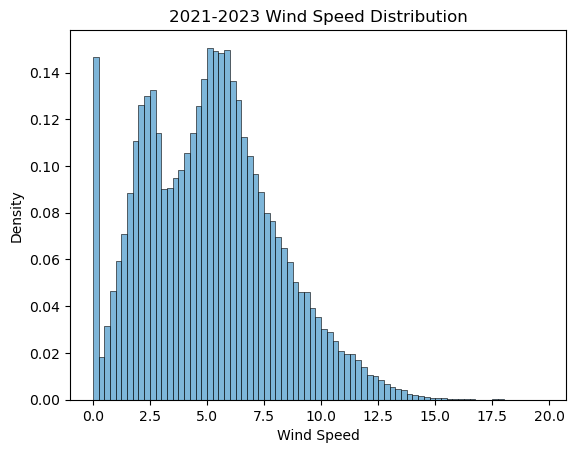

In [62]:
# plot the distribution of the data
sns.histplot(data=ws, binwidth=0.25, stat='density', color=sns.color_palette('Blues')[3])

plt.title(str(year_start)+"-"+str(year_end)+" Wind Speed Distribution")
plt.xlabel('Wind Speed')
plt.ylabel('Density')
plt.show()

There are a few values to the left. It can be noted that this area is most likely before the *cut-in wind speed*.

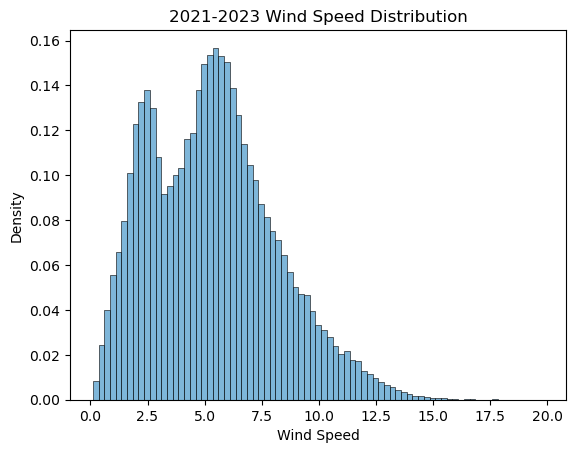

In [63]:
# drop rows with low WindSpeed values
ws_cutoff = 0.1
ws = ws[ws >= ws_cutoff]

# plot the distribution of the updated data
sns.histplot(data=ws, binwidth=0.25, stat='density', color=sns.color_palette('Blues')[3])

plt.title(str(year_start)+"-"+str(year_end)+" Wind Speed Distribution")
plt.xlabel('Wind Speed')
plt.ylabel('Density')
plt.show()

It can be observed that the wind distribution resembles a ***Weibull Distribution***. To quantify the improvement in generation from the regression models in terms of AEP, the wind speed data will be fitted to a *Weibull Distribution Curve* to approximate a realistic annual wind speed profile.

### Weibull Distribution Fitting
<sub> Reference: Onnen, H. (2021, October 22). *Probability Distributions with Python's Scipy*. Towards Data Science. Retrieved from https://towardsdatascience.com/probability-distributions-with-pythons-scipy-3da89bf60565 </sub>

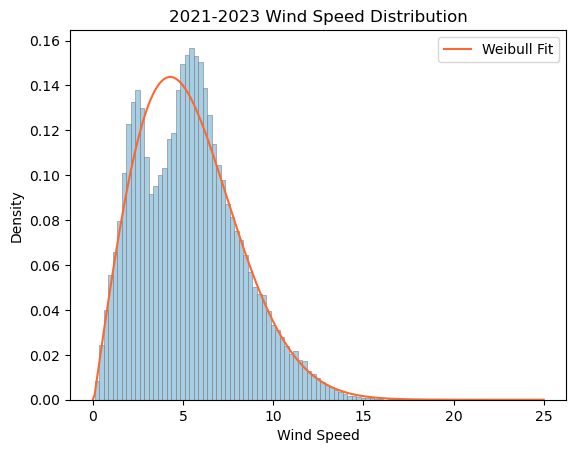

In [64]:
# Weibull distribution
shape, loc, scale = weibull_min.fit(ws, loc=0)

# plot the distribution of the data again
sns.histplot(data=ws, binwidth=0.25, stat='density', color=sns.color_palette('Blues')[2], edgecolor='gray')

# generate synthetic data to plot the Weibull curve
ws_x = np.linspace(0, ws_max, ws_max*10+1)
sns.lineplot(x=ws_x, y=weibull_min.pdf(ws_x, shape, loc, scale), label='Weibull Fit', color=sns.color_palette('YlOrRd')[3])

plt.title(str(year_start)+"-"+str(year_end)+" Wind Speed Distribution")
plt.xlabel('Wind Speed')
plt.ylabel('Density')
plt.show()

### Generating a Synthetic Annual Wind Data Based on Weibull Distribution

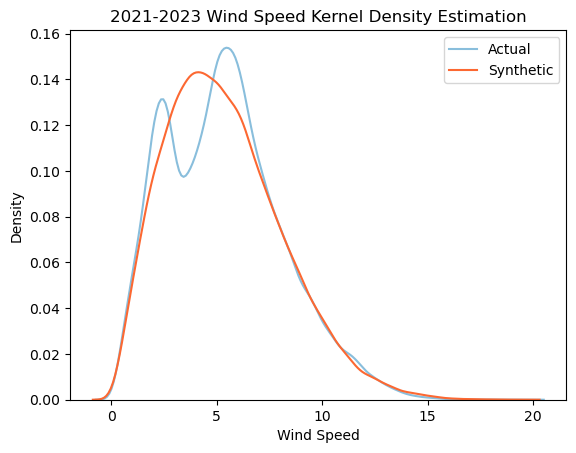

In [65]:
# generate synthetic wind speed data using random numbers following the fitted Weibull distribution
np.random.seed(42)
ws_syn = weibull_min.rvs(shape, loc, scale, size=365*24*int(60/gran))

# plot the KDE of the actual data
sns.kdeplot(data=ws, label='Actual', color=sns.color_palette('Blues')[2])

# plot the KDE of the synthetic data
sns.kdeplot(data=ws_syn, label='Synthetic', color=sns.color_palette('YlOrRd')[3])

plt.title(str(year_start)+"-"+str(year_end)+" Wind Speed Kernel Density Estimation")
plt.xlabel('Wind Speed')
plt.ylabel('Density')
plt.legend()
plt.show()

In [66]:
# comparison
print("Actual Average Wind Speed: %.4f" % np.average(ws))
print("Synthetic Average Wind Speed: %.4f" % np.average(ws_syn))

Actual Average Wind Speed: 5.3529
Synthetic Average Wind Speed: 5.3443


*Time series forecasting* could have been done if only more historical data was available.

### Quantifying the Annual Generation Using the Best Model and the Synthetic Wind Speed Profile

In [67]:
# predicting Power using the synthetic wind speed profile on the best model

if best_index_bef == 0:
    # Sigmoid 50th Quantile Reg
    y_bef_pred = wpc_equation(opt_params_bef[len(quantiles)], ws_syn.reshape(-1,1))
elif best_index_bef == 1:
    # Sigmoid OLS Reg
    y_bef_pred = wpc_equation(opt_params_bef[len(quantiles)+1], ws_syn.reshape(-1,1))
else:
    # other reg
    y_bef_pred = model_bef.predict(ws_syn.reshape(-1,1))

if best_index_aft == 0:
    # Sigmoid 50th Quantile Reg
    y_aft_pred = wpc_equation(opt_params_aft[len(quantiles)], ws_syn.reshape(-1,1))
elif best_index_aft == 1:
    # Sigmoid OLS Reg
    y_aft_pred = wpc_equation(opt_params_aft[len(quantiles)+1], ws_syn.reshape(-1,1))
else:
    # other reg
    y_aft_pred = model_aft.predict(ws_syn.reshape(-1,1))

# in case of negative values, replace with zero
y_bef_pred[y_bef_pred < 0] = 0
y_aft_pred[y_aft_pred < 0] = 0

# prediction results
y_bef_pred_total = y_bef_pred.sum() / (float(60)/gran)
y_aft_pred_total = y_aft_pred.sum() / (float(60)/gran)
y_pred_diff = y_aft_pred_total - y_bef_pred_total
print("Predicted Annual Generation (Before Improvement): " + "{:,.2f}".format(y_bef_pred_total)+" kWh")
print("Predicted Annual Generation (After Improvement): " + "{:,.2f}".format(y_aft_pred_total)+" kWh")
print("Predicted Annual Generation Difference: " + "{:,.2f}".format(y_pred_diff)+" kWh ("+
      "{:.2%}".format(y_pred_diff/y_bef_pred_total)+")")

Predicted Annual Generation (Before Improvement): 3,486,707.36 kWh
Predicted Annual Generation (After Improvement): 3,615,145.53 kWh
Predicted Annual Generation Difference: 128,438.17 kWh (3.68%)


These predictions, however, are not yet realistic because these are at 100% availability. To adjust for this, the actual availability from the data will be the basis of the percent of the time the turbine is down. This percentage will then be the basis of randomly placing zeros on the predictions, representing downtimes.

In [68]:
# take the most recent FULL YEARS of Availability data from the imported data
# (e.g. if 2023 data ends in July and full 2021-2022 data are imported, start from July 2021 instead of January 2021)

# use df1 (before rows with zero power values were removed) to see the actual distribution of the Availability data
avail = df1.copy().loc[df1.index > df1.index.max() - np.timedelta64(365 * (year_end - year_start), 'D'), "Availability"]

# calculate the average availability for the most recent full year(s)
ave_avail = avail.mean() / 100
print(" Average Availability = "+str(ave_avail))

 Average Availability = 0.9323723137648635


In [69]:
# calculate the number of Power values that should be zero to simulate the equivalent average availability from the actual data
zero_count = int(round(float(len(y_aft_pred)) * (1 - ave_avail),0))
np.random.seed(42)
zero_indexes = np.random.randint(0, len(y_aft_pred), zero_count)

print("zero indexes: "+str(zero_indexes))

zero indexes: [15795   860 38158 ... 50914 11240 32698]


In [70]:
# copying the predictions
y_bef_adj = y_bef_pred.copy()
y_aft_adj = y_aft_pred.copy()

# using the randomized indexes to replace values with zero in the copies
y_bef_adj[zero_indexes] = 0
y_aft_adj[zero_indexes] = 0

# results
y_bef_adj_total = y_bef_adj.sum() / (float(60)/gran)
y_aft_adj_total = y_aft_adj.sum() / (float(60)/gran)
y_adj_diff = y_aft_adj_total - y_bef_adj_total
print("Predicted Annual Generation (Before Improvement): " + "{:,.2f}".format(y_bef_adj_total)+" kWh")
print("Predicted Annual Generation (After Improvement): " + "{:,.2f}".format(y_aft_adj_total)+" kWh")
print("Predicted Annual Generation Difference: " + "{:,.2f}".format(y_adj_diff)+" kWh ("+
      "{:.2%}".format(y_adj_diff/y_bef_adj_total)+")")

Predicted Annual Generation (Before Improvement): 3,256,971.57 kWh
Predicted Annual Generation (After Improvement): 3,377,171.28 kWh
Predicted Annual Generation Difference: 120,199.71 kWh (3.69%)
